# EECS 498-007/598-005 Mini-Project :- Novel View Synthesis with NeRF

In the task of novel view synthesis, training set consists of a set of images of a scene where we know the camera parameters (intrinsic and extrinsic) for each image. The goal is to create a model that can synthesize images showing the scene from new viewpoints unseen in the training set. NeRF is one such methods which tries to represent a static scene as a continuous 5D function that outputs a density and the radiance emitted in each direction (θ, φ) at each point (x, y, z) in space. The density at each point acts like a differential opacity controlling how much radiance is accumulated by passing a ray through the point (x, y, z). NeRF paper [Mildenhall et al, ECCV 2020](https://arxiv.org/abs/2003.08934) tries to predict the density and the RGB color at some input point (x, y, z) and a input viewing direction using fully-connected neural network. 

# Setup Code
This portion consists of setting up the colab environment. You'll need to rerun this setup code each time you start the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import sys
import math, imageio

GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", "data")
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['drums_data_train.npz', 'drums_data_val.npz', 'drums_data_test.npz', 'lego_data_train.npz', 'lego_data_val.npz', 'lego_data_test.npz', 'lego_data.npz', 'lego_data400x400_train.npz', 'lego_data400x400_val.npz', 'lego_data400x400_test.npz', 'lego_data200x200_train.npz', 'lego_data200x200_val.npz', 'lego_data200x200_test.npz', 'drums_data100x100_train.npz', 'drums_data100x100_val.npz', 'drums_data100x100_test.npz', 'lego_data100x100_train.npz', 'lego_data100x100_val.npz', 'lego_data100x100_test.npz', 'legovideo (11).mp4', 'drumsvideo (4).mp4', '__pycache__', '.ipynb_checkpoints', 'utils.py']


Once we have successfully mounted the Google drive, we will do a sanity check to confirm the python files are loaded properly.

In [27]:
import os
from utils import hello_apna_nerf

hello_apna_nerf()

Hello Apna NeRF!


## Load Packages

Run necessary setup code and import useful packages


In [28]:
import math
import os
import time
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from utils import *

# for plotting
%matplotlib inline
plt.style.use("seaborn")  # Prettier plots
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 24
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

Define GPU dependent variable

In [6]:
if torch.cuda.is_available():
    print("Good to go!")
    device = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    device = torch.device("cpu")

Good to go!


# Contents

Our project is segmented into the following parts

1. Dataset preparation and loading
2. Model initializations
3. Training Regime
4. Inference


## Dataset preparation and loading

The original NeRF implementation trains on images of resolution 800x800. Due to the restrictions on Colab we decided to try training our model on downsampled low resolution images. Even after making changes to the model architectures (which are explained in the next section), we were running out of memory for resolutions 400x400 and 200x200. Therefore we decided to use 100x100 as suggested in tiny-nerf implementation. We took the aide of `load_blender_data` function from the original NeRF implementation to load the data from their dataset and then used `transforms.resize` from `skimage` library to resize the views in the batch format ,i.e., convert `(batch_size, 800, 800, 3)` to `(batch_size, 100, 100, 3)`.

The dataset contains 100 image for training, 100 images for validation and 200 images for testing.

For this task, we will be using two synthetic rendering of objects, `drums` and `lego` mentioned in the original NeRF paper.

(100, 100, 100, 4) (100, 4, 4) 138.88887889922103


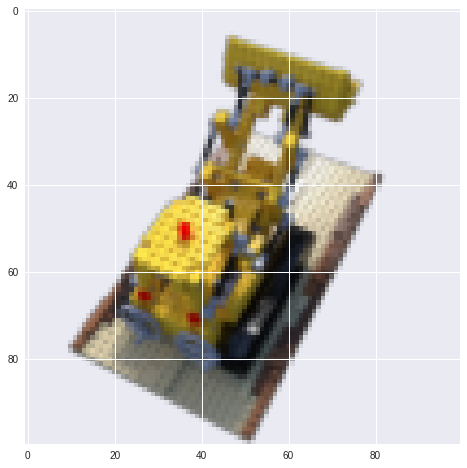

In [7]:
name = 'lego'
path = os.path.join(GOOGLE_DRIVE_PATH,name+'_data100x100_train.npz')
data = np.load(path,allow_pickle=True)
images = data['images']
poses = data['poses']
f = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, f)


# Similarly load the validation data.
path = os.path.join(GOOGLE_DRIVE_PATH,name+'_data100x100_val.npz')
data = np.load(path,allow_pickle=True)
testimg = data['images'][10]
testpose = data['poses'][10]

images = images[...,:3]
plt.imshow(testimg)
plt.show()

# Model Initializations

To implement the NeRF model and infer results as mentioned in the original paper, we had to look for other model architectures due to the GPU restrictions in Colab. The code release for NeRF included `tiny-nerf.ipynb`, that ran on low res images and modified neural architecture so that the model can be trained in Colab. Tiny-NeRF was implemented in Tensorflow so we re-implemented it in PyTorch with small changes to try and make it more understandable and improve the computation flow.

We experimented with multiple model architecture derived from Tiny-NeRF and have provided the training results for `lego` scene on 3 models, namely:

* Original Tiny-NeRF model architecture
* Tiny-NeRF architecture but reduced the number of layers
* Encoder-Decoder style architecture



## Model 1

**Original Tiny-NeRF**

The model consists of 8 fully-connected layers with width=256. The original NeRF extracts $\sigma$(the density parameter) and then applied couple layers and sigmoid activation in the end to get $rgb$ values. On the other hand Tiny-NeRF ignores the view direction and applied an linear layer to get a 4-dim vector and then applies `ReLU` on the last value to get $\sigma$ and `Sigmoid` on the first three input to get the $rgb$ value. We tweaked this a bit by concating the positional encoded view direction to the hidden layer before sending it to the last layer. The model initialization is as defined below.

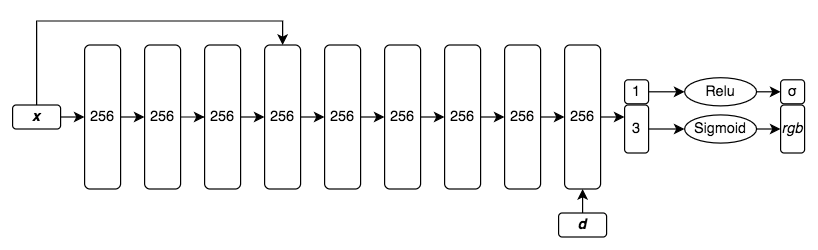

In [4]:
class NeRF_MLP_original(nn.Module):
  def __init__(self, W: int, inp_dim: int):
    super().__init__()
    self.enc = nn.Sequential(
                nn.Linear(inp_dim,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU()
                )
    self.dec = nn.Sequential(
                nn.Linear(inp_dim+W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU()
                )
    self.feat_to_sigma_rgb = nn.Sequential(
                        nn.Linear(W+inp_dim,4)
                        )
    
  def forward(self, x, d):
    h = self.enc(x)
    feat = self.dec(torch.concat([x,h],dim=-1))
    obj = self.feat_to_sigma_rgb(torch.concat([feat,d], dim=-1))
    return obja

In [6]:
model_tiny_nerf_original = NeRF_MLP_original(W=256, inp_dim=39)
summary(model_tiny_nerf_original)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       10,240
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       65,792
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       65,792
|    └─ReLU: 2-6                         --
|    └─Linear: 2-7                       65,792
|    └─ReLU: 2-8                         --
├─Sequential: 1-2                        --
|    └─Linear: 2-9                       75,776
|    └─ReLU: 2-10                        --
|    └─Linear: 2-11                      65,792
|    └─ReLU: 2-12                        --
|    └─Linear: 2-13                      65,792
|    └─ReLU: 2-14                        --
|    └─Linear: 2-15                      65,792
|    └─ReLU: 2-16                        --
|    └─Linear: 2-17                      65,792
|    └─ReLU: 2-18                        --
├─Sequential: 1-3                  

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       10,240
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       65,792
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       65,792
|    └─ReLU: 2-6                         --
|    └─Linear: 2-7                       65,792
|    └─ReLU: 2-8                         --
├─Sequential: 1-2                        --
|    └─Linear: 2-9                       75,776
|    └─ReLU: 2-10                        --
|    └─Linear: 2-11                      65,792
|    └─ReLU: 2-12                        --
|    └─Linear: 2-13                      65,792
|    └─ReLU: 2-14                        --
|    └─Linear: 2-15                      65,792
|    └─ReLU: 2-16                        --
|    └─Linear: 2-17                      65,792
|    └─ReLU: 2-18                        --
├─Sequential: 1-3                  

## Model 2

**Tiny-NeRF reduced layers**

We experimented by reducing the number of layers to 6 but kept the width=256. We observed that the results this model was not that different from the original Tiny-NeRF implementation. The model initialization is as defined below.

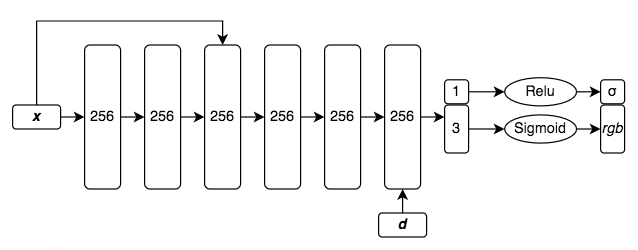

In [7]:
class NeRF_MLP_reduced(nn.Module):
  def __init__(self, W: int, inp_dim: int):
    super().__init__()
    self.enc = nn.Sequential(
                nn.Linear(inp_dim,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU()
                )
    self.dec = nn.Sequential(
                nn.Linear(inp_dim+W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU(),
                nn.Linear(W,W),
                nn.ReLU()
                )
    self.feat_to_sigma_rgb = nn.Sequential(
                        nn.Linear(W+inp_dim,4)
                        )
    self.feat_to_sigma = nn.Sequential(
                        nn.Linear(W,1),
                        nn.ReLU())
    
  def forward(self, x, d):
    h = self.enc(x)
    feat = self.dec(torch.concat([x,h],dim=-1))
    obj = self.feat_to_sigma_rgb(torch.concat([feat,d], dim=-1))
    return obj

In [8]:
model_tiny_nerf_reduced = NeRF_MLP_reduced(W=256, inp_dim=39)
summary(model_tiny_nerf_reduced)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       10,240
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       65,792
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       65,792
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─Linear: 2-7                       75,776
|    └─ReLU: 2-8                         --
|    └─Linear: 2-9                       65,792
|    └─ReLU: 2-10                        --
|    └─Linear: 2-11                      65,792
|    └─ReLU: 2-12                        --
├─Sequential: 1-3                        --
|    └─Linear: 2-13                      1,184
├─Sequential: 1-4                        --
|    └─Linear: 2-14                      257
|    └─ReLU: 2-15                        --
Total params: 350,625
Trainable params: 350,625
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       10,240
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       65,792
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       65,792
|    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
|    └─Linear: 2-7                       75,776
|    └─ReLU: 2-8                         --
|    └─Linear: 2-9                       65,792
|    └─ReLU: 2-10                        --
|    └─Linear: 2-11                      65,792
|    └─ReLU: 2-12                        --
├─Sequential: 1-3                        --
|    └─Linear: 2-13                      1,184
├─Sequential: 1-4                        --
|    └─Linear: 2-14                      257
|    └─ReLU: 2-15                        --
Total params: 350,625
Trainable params: 350,625
Non-trainable params: 0

## Model 3

**Encoder-Decoder Architecture**

Next implemented a encoder-decoder type architecture to see if how it affects our results. The encoder model reduces the width from 512 to 100 and decoder width goes from 100 to 512. Again we haven't seen much difference in the results. The model initialization is as defined below.

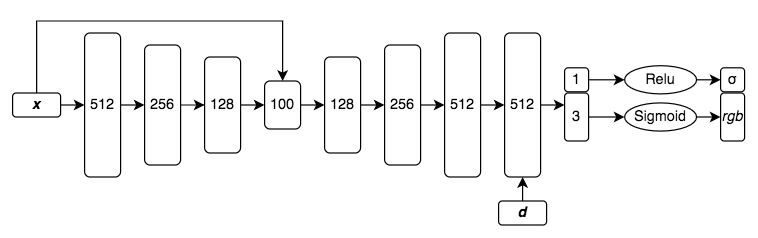

In [10]:
class NeRF_MLP_autoencoder(nn.Module):
  def __init__(self, W: int, inp_dim: int):
    super().__init__()
    self.enc = nn.Sequential(
                nn.Linear(inp_dim,512),
                nn.ReLU(),
                nn.Linear(512,256),
                nn.ReLU(),
                nn.Linear(256,128),
                nn.ReLU(),
                nn.Linear(128,100),
                nn.ReLU()
                )
    self.dec = nn.Sequential(
                nn.Linear(inp_dim+100,128),
                nn.ReLU(),
                nn.Linear(128,256),
                nn.ReLU(),
                nn.Linear(256,512),
                nn.ReLU(),
                nn.Linear(512,512),
                nn.ReLU()
                )
    self.feat_to_sigma_rgb = nn.Sequential(
                        nn.Linear(W+inp_dim,4)
                        )
    self.feat_to_sigma = nn.Sequential(
                        nn.Linear(W,1),
                        nn.ReLU())
    
  def forward(self, x, d):
    h = self.enc(x)
    feat = self.dec(torch.concat([x,h],dim=-1))
    obj = self.feat_to_sigma_rgb(torch.concat([feat,d], dim=-1))
    return obj

In [11]:
model_tiny_nerf_autoencoder = NeRF_MLP_autoencoder(W=256, inp_dim=39)
summary(model_tiny_nerf_original)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       10,240
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       65,792
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       65,792
|    └─ReLU: 2-6                         --
|    └─Linear: 2-7                       65,792
|    └─ReLU: 2-8                         --
├─Sequential: 1-2                        --
|    └─Linear: 2-9                       75,776
|    └─ReLU: 2-10                        --
|    └─Linear: 2-11                      65,792
|    └─ReLU: 2-12                        --
|    └─Linear: 2-13                      65,792
|    └─ReLU: 2-14                        --
|    └─Linear: 2-15                      65,792
|    └─ReLU: 2-16                        --
|    └─Linear: 2-17                      65,792
|    └─ReLU: 2-18                        --
├─Sequential: 1-3                  

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       10,240
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       65,792
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       65,792
|    └─ReLU: 2-6                         --
|    └─Linear: 2-7                       65,792
|    └─ReLU: 2-8                         --
├─Sequential: 1-2                        --
|    └─Linear: 2-9                       75,776
|    └─ReLU: 2-10                        --
|    └─Linear: 2-11                      65,792
|    └─ReLU: 2-12                        --
|    └─Linear: 2-13                      65,792
|    └─ReLU: 2-14                        --
|    └─Linear: 2-15                      65,792
|    └─ReLU: 2-16                        --
|    └─Linear: 2-17                      65,792
|    └─ReLU: 2-18                        --
├─Sequential: 1-3                  

# Training Regime

We have followed the implementation of Tiny-NeRF and coded the training regime in PyTorch. We have chosen `N_sample=64` and `N_iter=2000`. In each iteration we randomly select an image, generate a direction rays, `dir_rays` and sample `N_samples` points along the rays to create `origin_rays` using `project_rays` function. Positional encoding is then applied on `origin_rays` and `dir_rays` with 6 embedded dimension. We pass the encoded points and rays to our model and predict the RGB color and corresponding opacity for each of the 3D points. We then use this information to render color for each pixel. We then take an mean squared loss between the predicted colors(`pred_rgb`) and target color of each pixels. The gradient are calculated and backprogated w.r.t the MSE loss.



The implementation for sampling points along rays, runnnig the model on batches of 3D points and rendering an image based on the predicted $rgb$ and $\sigma$ values has been done in `render_rays()`. We have followed the mathematical formulation of differentiable volumen rendering and implemented the function in PyTorch.

Sampling from the rays follows the stratified sampling process as defined in Equation 2 in the paper(which has been mentioned below). We evenly segment `N = N_samples` samples between $[t_n,t_f]$(where $t_n$ and $t_f$ are near and far planes respectively). For each each interval $[t_i,t_{i+1}]$ we uniformly sample a point in the interval. 
$$t_i \sim \mathcal{U}\big[ t_n+\frac{i-1}{N}(t_f - t_n), t_n+\frac{i}{N}(t_f - t_n) \big]$$


Once we have the predicted $rgb$ and $\sigma$ values for each point in a ray we use the following rendering function, as mentioned in the paper, to get the color at the pixel through which the ray was projected.
$$\hat{C}(\textbf{r}) = \sum_{i=1}^N exp\left(-\sum_{j=1}^{i-1}\sigma_j\delta_j\right) \Bigg(1-exp(-\sigma_i\delta_i) \Bigg)\textbf{c}_i$$
where $\delta_i = t_{i+1} - t_i$ and $c_i$ is color value. 



In [11]:
def convert_to_batch(model,pts, rays_d, batch_size):
  '''
  Call model in smaller batches
  Input:-
    model : pytorch model instance describing MLP model.
    pts : `N_sample` samples between [tn,tf] along the rays `rays_d`for each pixels in the image
    rays_d : direction rays for each pixel in the image.
    batch_size : Maximum number of rays to process simultaneously. Use it to control memory usage
  
  Output:-
    model output predicting `rgb` and `sigma` value for each pixels in the image.
  '''
  return torch.cat([model.forward(pts[i:i+batch_size],rays_d[i:i+batch_size]) for i in range(0,pts.shape[0],batch_size)],0)



def render_rays(model,rays_o, rays_d, near, far, N_samples, rand=False, batch_size=1024,L=6):
  '''
  Rendering function

  Input:-
    model : Pytorch model instance describing MLP model.
    rays_o : origin ray for each pixels in the image.
    rays_d : direction ray for each pixel in the image.
    near : Near plane.
    far : Far plane.
    N_samples : Number of sample to take along each ray.
    batch_size : Maximum number of rays to process simultaneously. Use it to control memory usage
  
  Output:-
    rgb : Estimated RGB color of a ray.
    depth : Depth map.
    acc : accumulated opacity along each ray. 
  '''
  z_vals = torch.linspace(near,far,N_samples,dtype=rays_o.dtype,device=rays_o.device)
  if(rand):
    sz = list(rays_o.shape[:-1]) + [N_samples]
    temp = torch.rand(sz)*(far-near)/N_samples
    z_vals = z_vals.unsqueeze(0).unsqueeze(0) + temp.to(rays_o)
  pts = rays_o.unsqueeze(-2) + rays_d.unsqueeze(-2)*z_vals.unsqueeze(-1)

  # Run model
  H, W, P, PP = pts.shape
  pts = pts.reshape(-1,3)
  pts = positional_encoding(pts,L)
  
  rays_d = rays_d.unsqueeze(-2)
  rays_d = rays_d.repeat(1, 1, P, 1).reshape(-1,3)
  rays_d = positional_encoding(rays_d, L)
  
  obj = convert_to_batch(model,pts,rays_d,batch_size)
  out_rgb = torch.sigmoid(obj[...,:3])
  out_sigma = torch.relu(obj[...,-1])
  out_rgb = out_rgb.reshape(H, W, P, 3)
  out_sigma = out_sigma.reshape(H, W, P)

  # Do Volume rendering
  diff = z_vals[...,1:]-z_vals[...,:-1]

  sz = list(diff.shape[:-1])+[1]
  distance = torch.concat((diff,torch.ones(sz,dtype=diff.dtype,device=diff.device)*1e10),axis=-1)
  alpha = 1 - torch.exp(-out_sigma*distance)
  
  sz = list(alpha.shape[:-1]) + [1]
  apx = torch.cat([torch.ones(sz,dtype=z_vals.dtype,device=z_vals.device),1.0 -alpha + 1e-10],-1)
  weights = alpha * torch.cumprod(apx,-1)[...,:-1]

  rgb = torch.sum(weights.unsqueeze(-1)*out_rgb,-2)
  depth = torch.sum(weights*z_vals,-1)
  acc = torch.sum(weights,-1)
  
  return rgb,depth,acc


Before training, we need to define the hyper-parameters as a Python dictionary. In order to keep the memory-footprint somewhat reasonable, we keep the number of samples (```num_samples```) as 64, you can always increase this for slightly better results.

In [12]:
hparams = {
    'network_width': 256,
    'lr': 5e-3,
    'iterations': 2000,
    'num_samples': 64,
    'L': 6,
    'batch_size': 1024*64,
    'near': 2.0,
    'far': 6.0
}

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loss at iteration 0 is 0.08984845131635666
PSNR at iteration 0 is 9.351119677262307
SSIM at iteration 0 is 0.02072270088350784


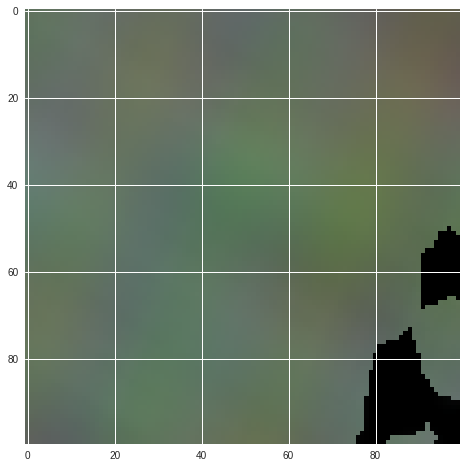

Loss at iteration 25 is 0.06917143613100052
PSNR at iteration 25 is 13.322672296150198
SSIM at iteration 25 is 0.006051962497295827


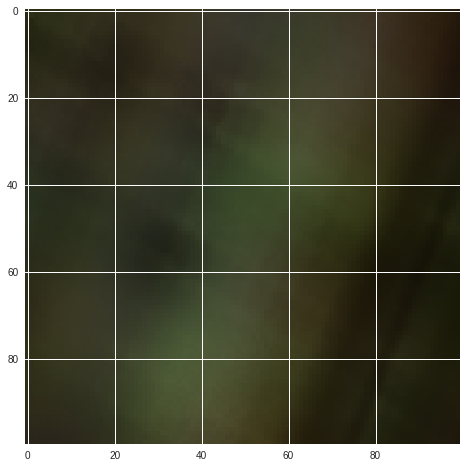

Loss at iteration 50 is 0.0611664280295372
PSNR at iteration 50 is 13.87115972453255
SSIM at iteration 50 is 0.2748982715416685


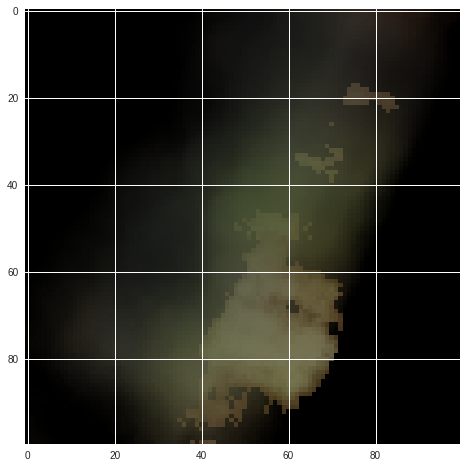

Loss at iteration 75 is 0.02990446798503399
PSNR at iteration 75 is 16.281981045222892
SSIM at iteration 75 is 0.45443408685727593


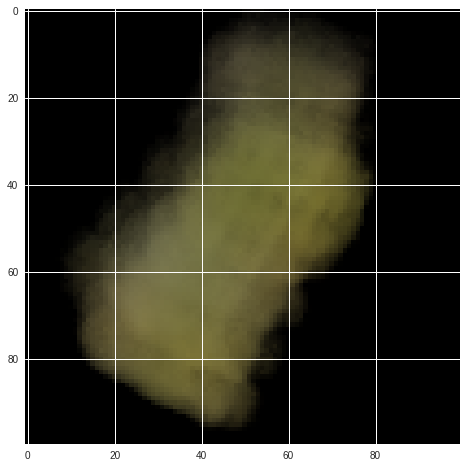

Loss at iteration 100 is 0.014894329942762852
PSNR at iteration 100 is 17.853823636462874
SSIM at iteration 100 is 0.5777640369706507


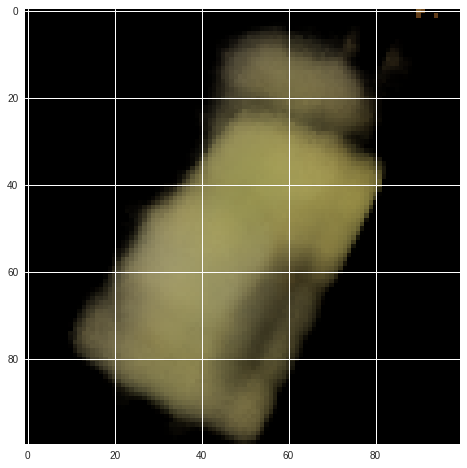

Loss at iteration 125 is 0.01741575449705124
PSNR at iteration 125 is 19.27109282734379
SSIM at iteration 125 is 0.6610113449600077


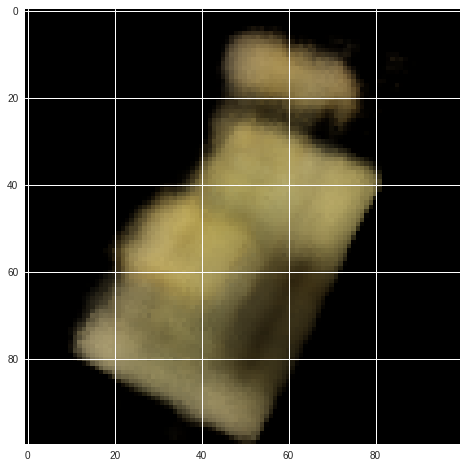

Loss at iteration 150 is 0.009826678782701492
PSNR at iteration 150 is 19.36006600678186
SSIM at iteration 150 is 0.6719577208416873


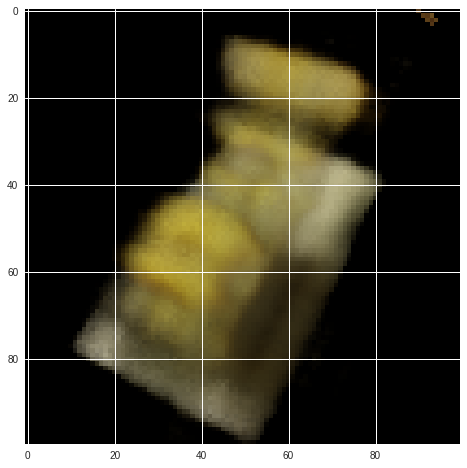

Loss at iteration 175 is 0.011379976756870747
PSNR at iteration 175 is 19.527763593080056
SSIM at iteration 175 is 0.6600845326250899


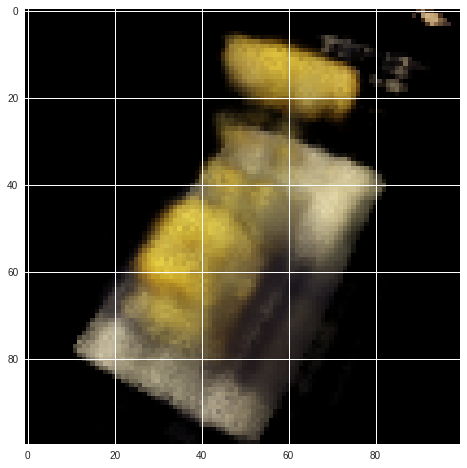

Loss at iteration 200 is 0.01034572720527649
PSNR at iteration 200 is 21.131026572668986
SSIM at iteration 200 is 0.7673051128397754


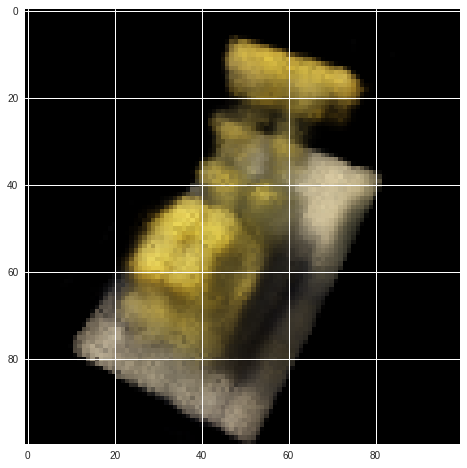

Loss at iteration 225 is 0.007272888440638781
PSNR at iteration 225 is 21.477761870267774
SSIM at iteration 225 is 0.7618748560283883


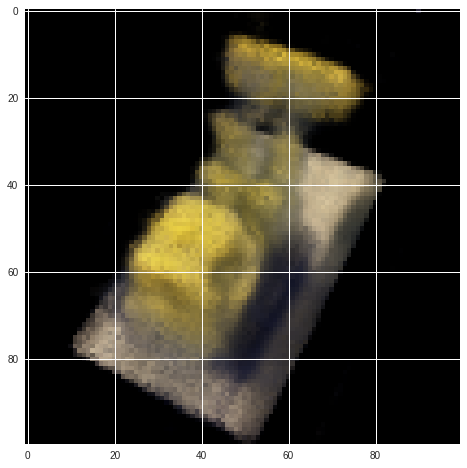

Loss at iteration 250 is 0.006504801567643881
PSNR at iteration 250 is 21.30874927677883
SSIM at iteration 250 is 0.7690825401811738


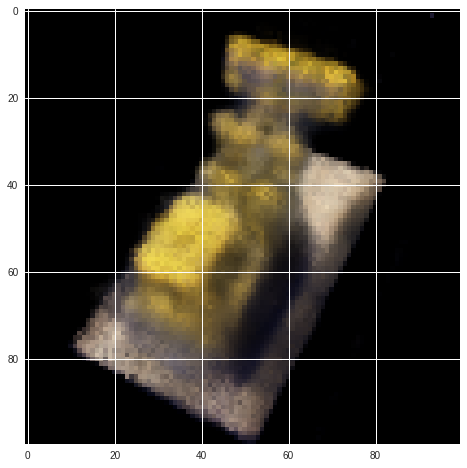

Loss at iteration 275 is 0.006277529988437891
PSNR at iteration 275 is 21.75254867207434
SSIM at iteration 275 is 0.7736028567285292


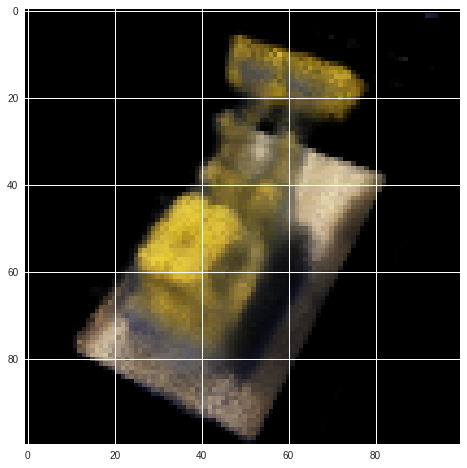

Loss at iteration 300 is 0.004431765992194414
PSNR at iteration 300 is 21.85930654718819
SSIM at iteration 300 is 0.7979829844635696


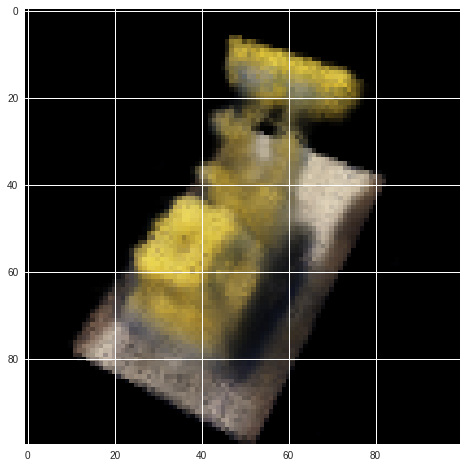

Loss at iteration 325 is 0.007179539185017347
PSNR at iteration 325 is 22.21757663227115
SSIM at iteration 325 is 0.7977635432633026


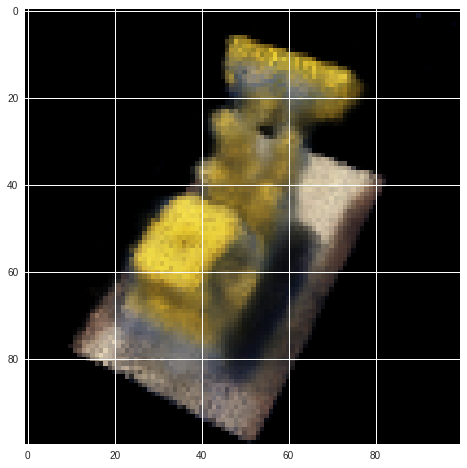

Loss at iteration 350 is 0.00425373762845993
PSNR at iteration 350 is 22.653896018160403
SSIM at iteration 350 is 0.8144532612925197


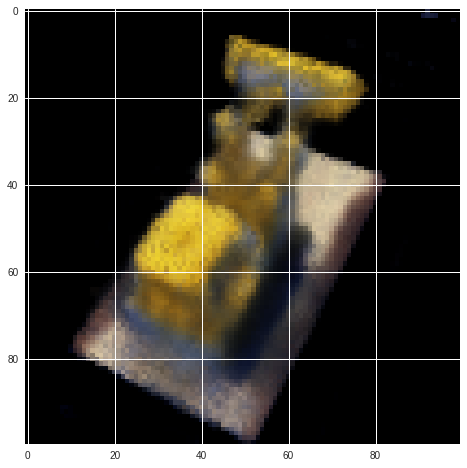

Loss at iteration 375 is 0.005464671179652214
PSNR at iteration 375 is 22.668704862917913
SSIM at iteration 375 is 0.8058668274667254


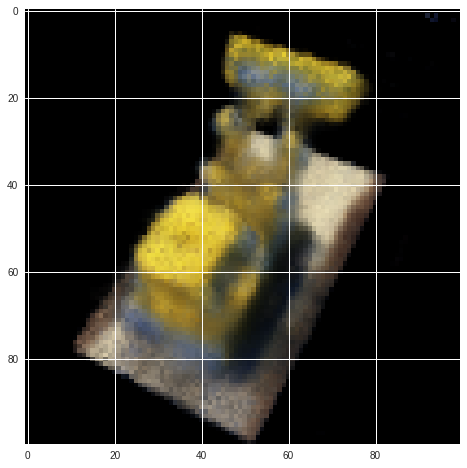

Loss at iteration 400 is 0.006196189671754837
PSNR at iteration 400 is 22.729296666688015
SSIM at iteration 400 is 0.816066218593399


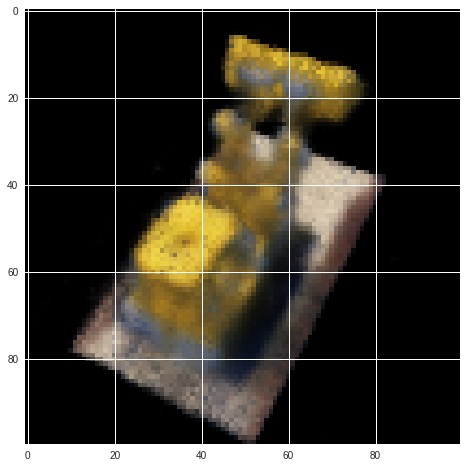

Loss at iteration 425 is 0.0031795825343579054
PSNR at iteration 425 is 22.99120053978021
SSIM at iteration 425 is 0.8271035149665409


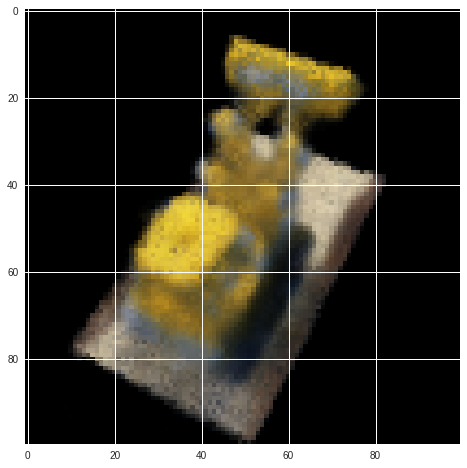

Loss at iteration 450 is 0.0047976355999708176
PSNR at iteration 450 is 23.169424396236764
SSIM at iteration 450 is 0.830830151354114


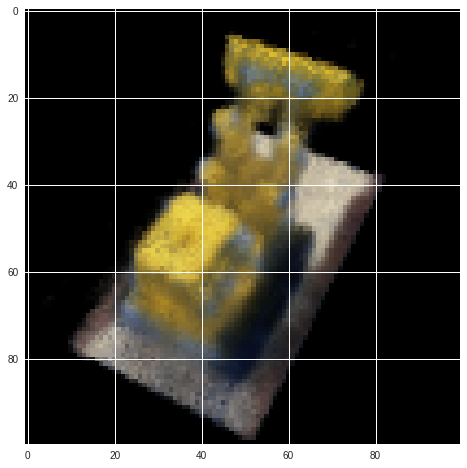

Loss at iteration 475 is 0.006317902822047472
PSNR at iteration 475 is 22.435869896812317
SSIM at iteration 475 is 0.793285262971681


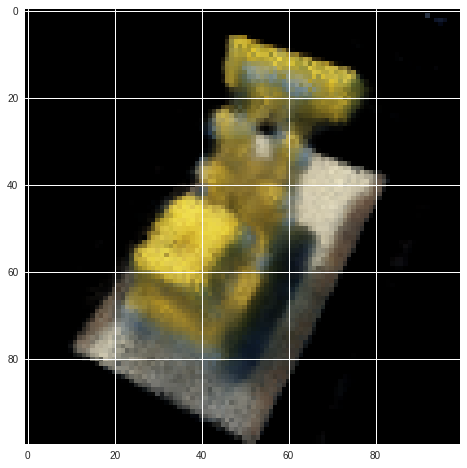

Loss at iteration 500 is 0.002986646955832839
PSNR at iteration 500 is 22.58916038858136
SSIM at iteration 500 is 0.7714129025352451


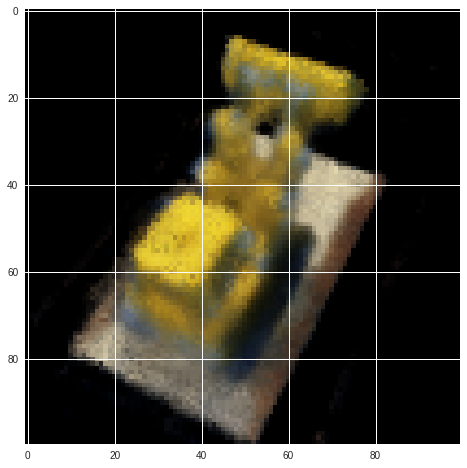

Loss at iteration 525 is 0.0038611614145338535
PSNR at iteration 525 is 22.615721462956945
SSIM at iteration 525 is 0.82033980184496


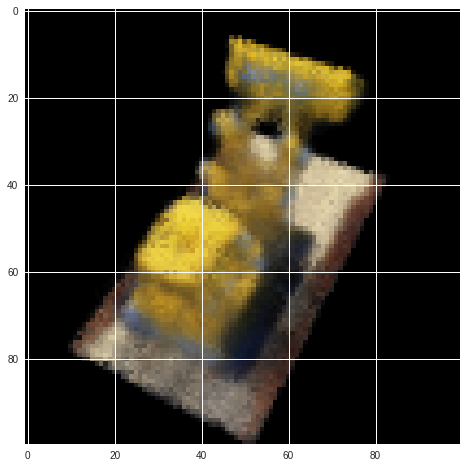

Loss at iteration 550 is 0.0038993200287222862
PSNR at iteration 550 is 22.6316941408502
SSIM at iteration 550 is 0.8177339189414105


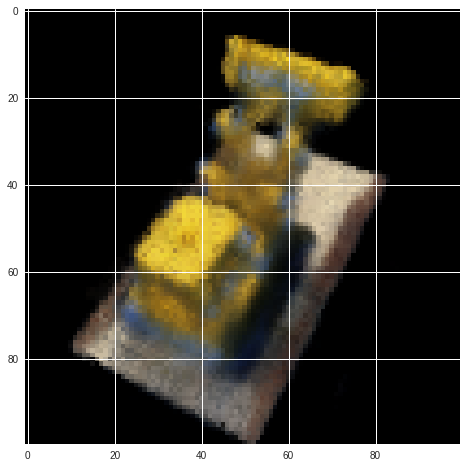

Loss at iteration 575 is 0.0031026434153318405
PSNR at iteration 575 is 23.226719363081404
SSIM at iteration 575 is 0.836137216848887


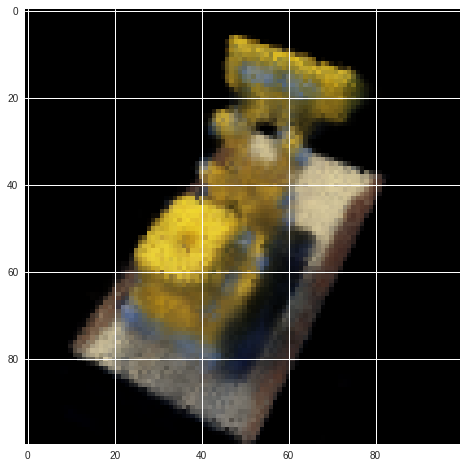

Loss at iteration 600 is 0.002459199633449316
PSNR at iteration 600 is 23.375692075334374
SSIM at iteration 600 is 0.8404112943486173


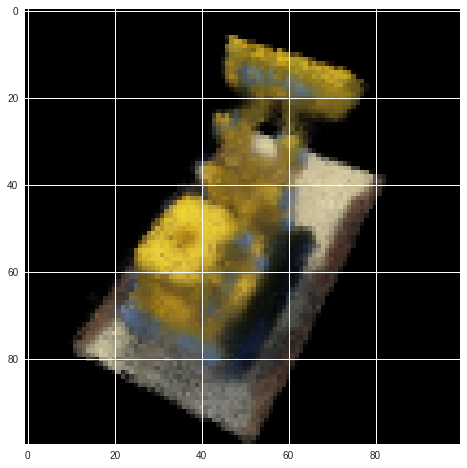

Loss at iteration 625 is 0.0030101740267127752
PSNR at iteration 625 is 22.628488422533234
SSIM at iteration 625 is 0.8253509495993806


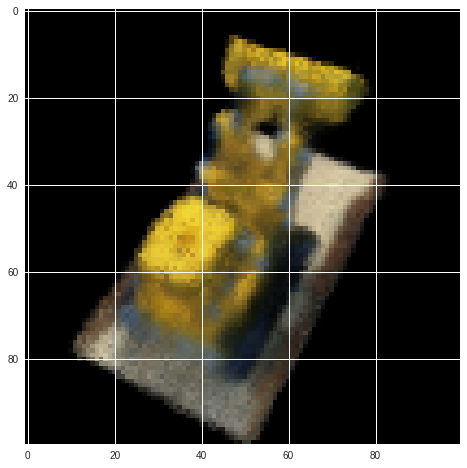

Loss at iteration 650 is 0.005484141409397125
PSNR at iteration 650 is 22.58883318994177
SSIM at iteration 650 is 0.8376094145574474


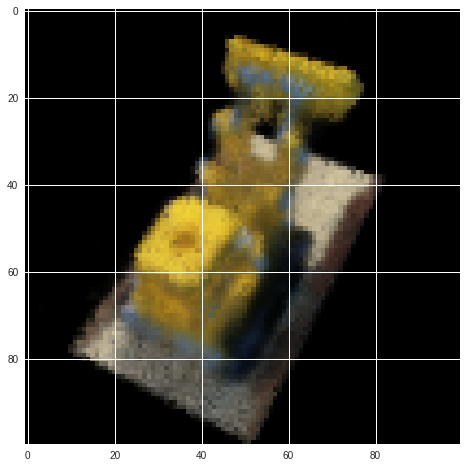

Loss at iteration 675 is 0.0027683039661496878
PSNR at iteration 675 is 23.95459551649479
SSIM at iteration 675 is 0.8613446615557139


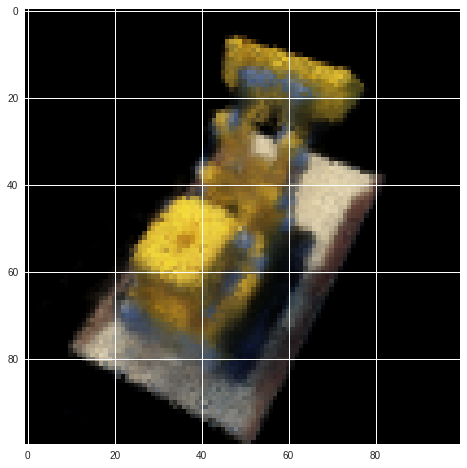

Loss at iteration 700 is 0.0031793920788913965
PSNR at iteration 700 is 23.396500252110137
SSIM at iteration 700 is 0.847525273067937


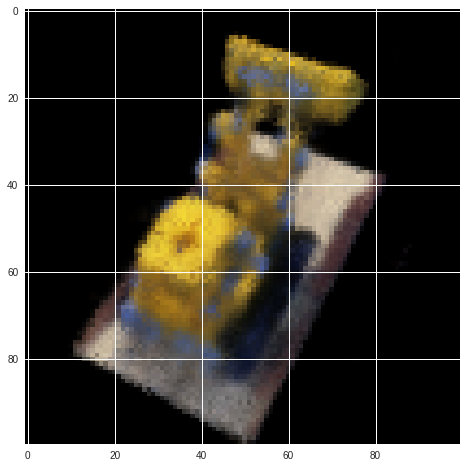

Loss at iteration 725 is 0.003815148724243045
PSNR at iteration 725 is 23.092799859126902
SSIM at iteration 725 is 0.8477458432904343


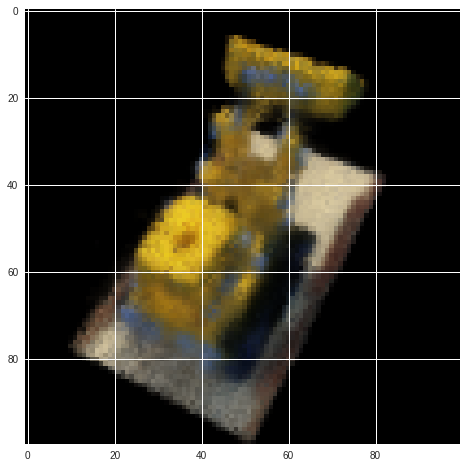

Loss at iteration 750 is 0.003727197414264083
PSNR at iteration 750 is 23.999092460601155
SSIM at iteration 750 is 0.8618204069118993


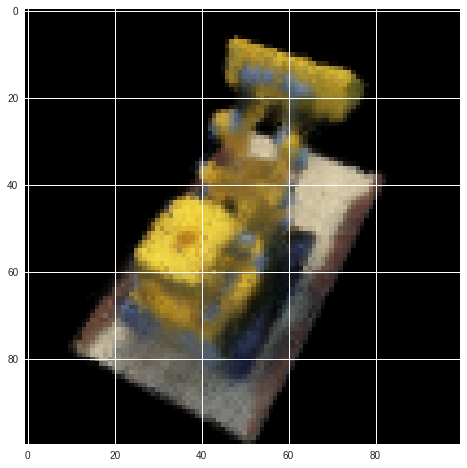

Loss at iteration 775 is 0.00289603928104043
PSNR at iteration 775 is 23.482599053625762
SSIM at iteration 775 is 0.8404398868244779


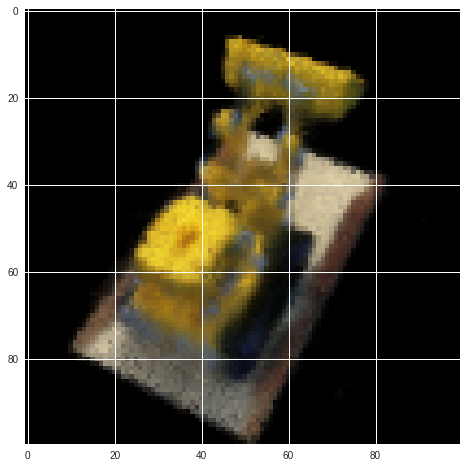

Loss at iteration 800 is 0.0035844140220433474
PSNR at iteration 800 is 23.666209262370707
SSIM at iteration 800 is 0.8514804267036176


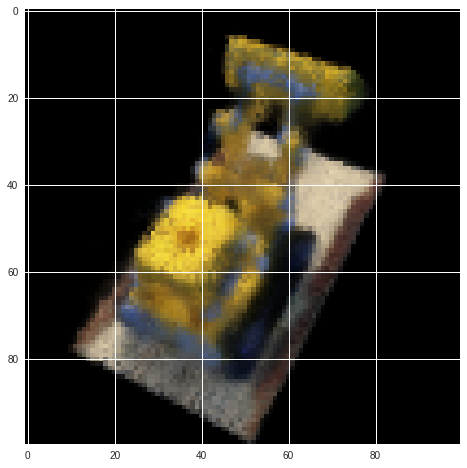

Loss at iteration 825 is 0.004033850505948067
PSNR at iteration 825 is 23.289017569883274
SSIM at iteration 825 is 0.8505025402366156


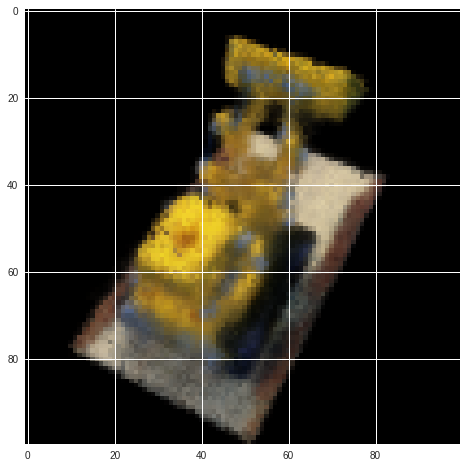

Loss at iteration 850 is 0.0030378049705177546
PSNR at iteration 850 is 23.278006714397932
SSIM at iteration 850 is 0.8485078177318641


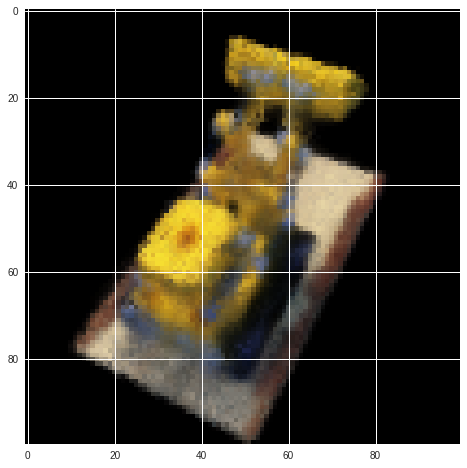

Loss at iteration 875 is 0.001997994026169181
PSNR at iteration 875 is 23.272632787374334
SSIM at iteration 875 is 0.8508095814116106


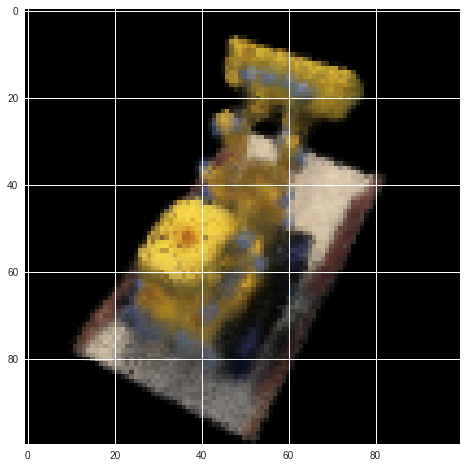

Loss at iteration 900 is 0.003687135875225067
PSNR at iteration 900 is 23.715407098324302
SSIM at iteration 900 is 0.8595907225454451


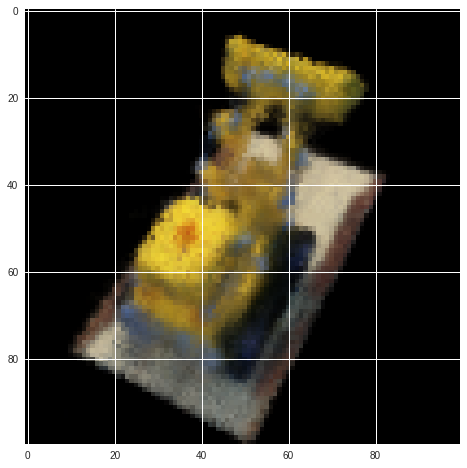

Loss at iteration 925 is 0.001781513332389295
PSNR at iteration 925 is 24.78637380499677
SSIM at iteration 925 is 0.8813336246217593


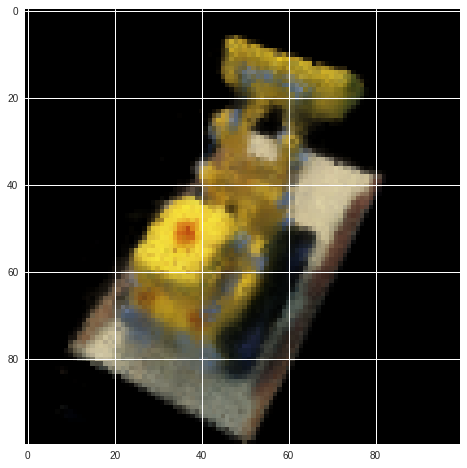

Loss at iteration 950 is 0.003620012430474162
PSNR at iteration 950 is 24.206989920264306
SSIM at iteration 950 is 0.8623221228010696


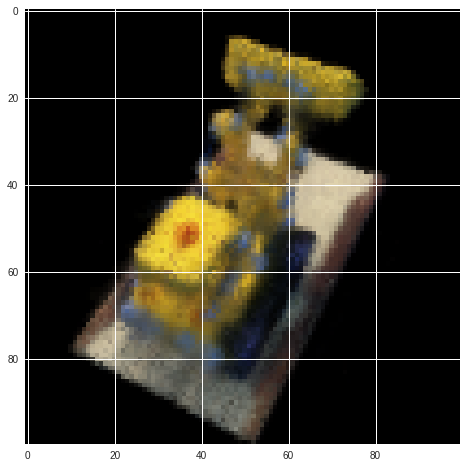

Loss at iteration 975 is 0.003326813690364361
PSNR at iteration 975 is 23.97748492512362
SSIM at iteration 975 is 0.8657718476855822


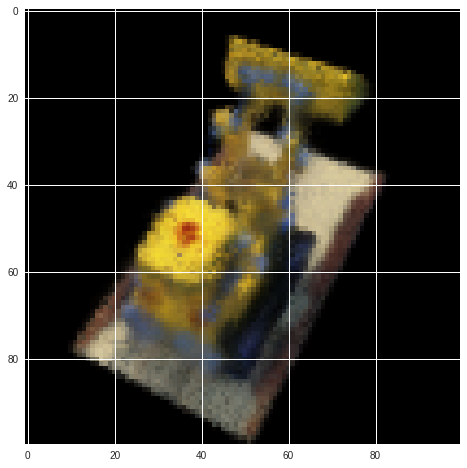

Loss at iteration 1000 is 0.0033783346880227327
PSNR at iteration 1000 is 23.97898216953135
SSIM at iteration 1000 is 0.8609633231512024


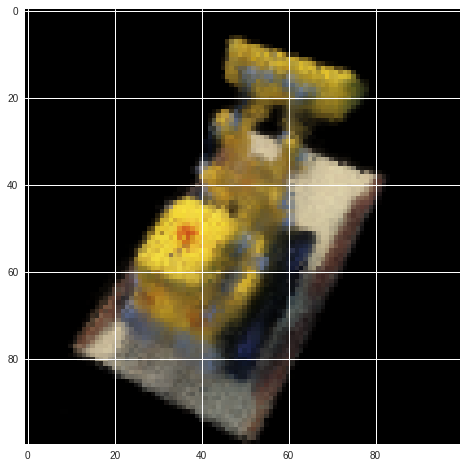

Loss at iteration 1025 is 0.003959475550800562
PSNR at iteration 1025 is 23.22952126029255
SSIM at iteration 1025 is 0.8511987664254876


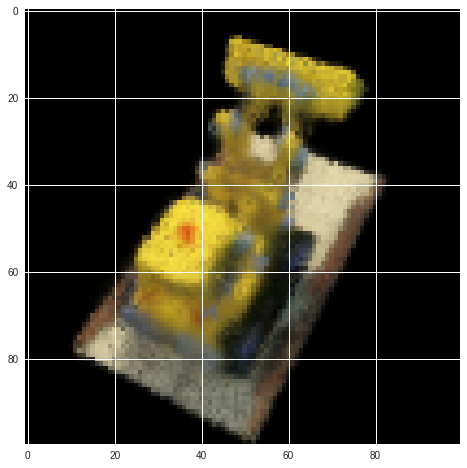

Loss at iteration 1050 is 0.0037412107922136784
PSNR at iteration 1050 is 23.73655696988191
SSIM at iteration 1050 is 0.8604241102936805


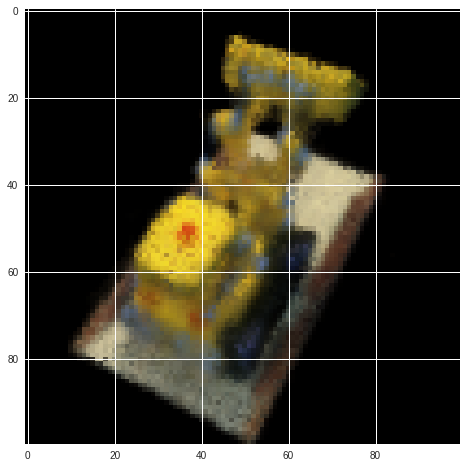

Loss at iteration 1075 is 0.002261171583086252
PSNR at iteration 1075 is 24.016011529496254
SSIM at iteration 1075 is 0.8633307073823183


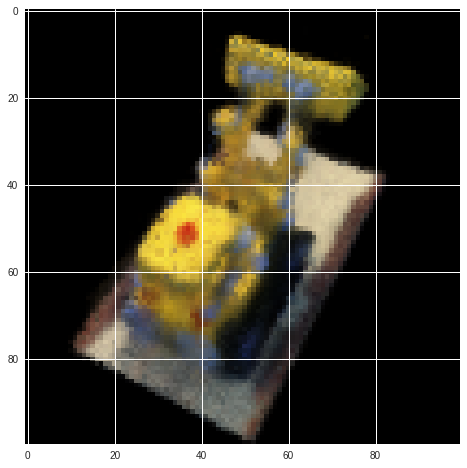

Loss at iteration 1100 is 0.0021772461477667093
PSNR at iteration 1100 is 23.76697194722124
SSIM at iteration 1100 is 0.8311317118005499


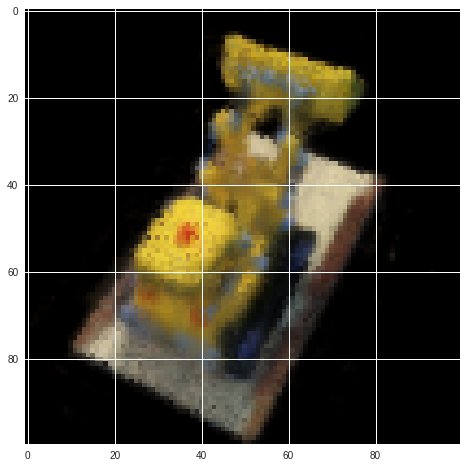

Loss at iteration 1125 is 0.002043407177552581
PSNR at iteration 1125 is 24.201491740592765
SSIM at iteration 1125 is 0.8575956503351958


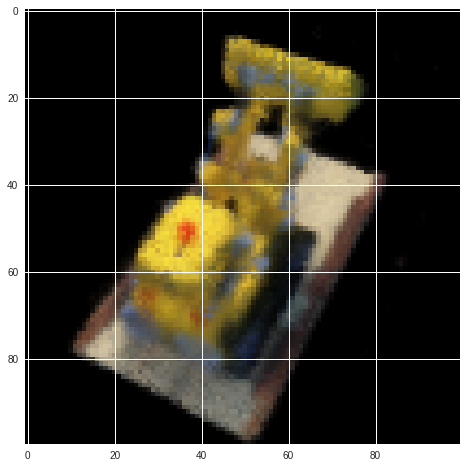

Loss at iteration 1150 is 0.002648640424013138
PSNR at iteration 1150 is 24.171677317718498
SSIM at iteration 1150 is 0.8626209918737601


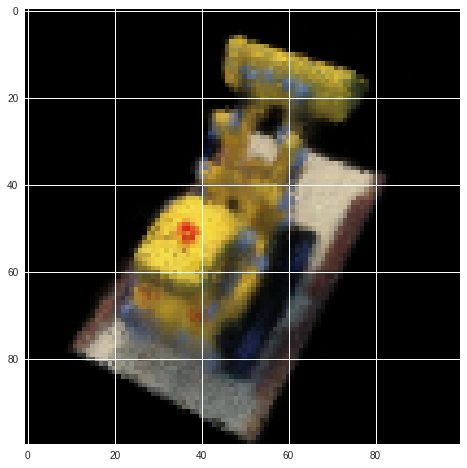

Loss at iteration 1175 is 0.005109617952257395
PSNR at iteration 1175 is 23.99954805364362
SSIM at iteration 1175 is 0.8716989478637022


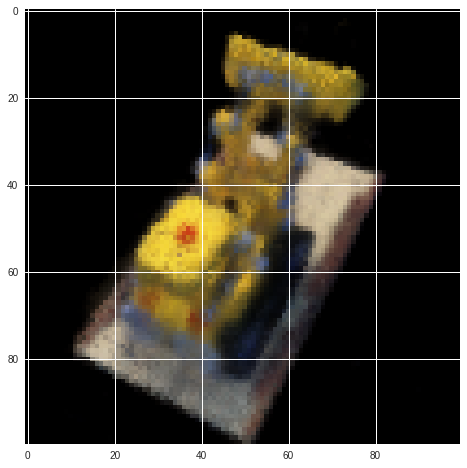

Loss at iteration 1200 is 0.0026964254211634398
PSNR at iteration 1200 is 24.143329076089977
SSIM at iteration 1200 is 0.8687686769432237


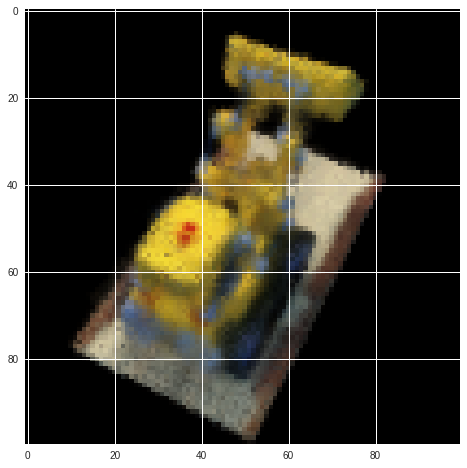

Loss at iteration 1225 is 0.003840720746666193
PSNR at iteration 1225 is 24.48914697497144
SSIM at iteration 1225 is 0.8779877020359226


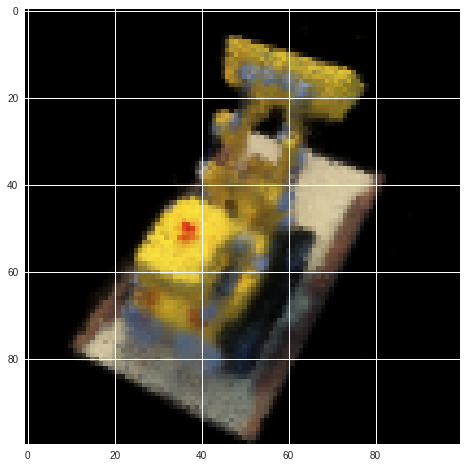

Loss at iteration 1250 is 0.0034238009247928858
PSNR at iteration 1250 is 24.73055744466267
SSIM at iteration 1250 is 0.8832700964369179


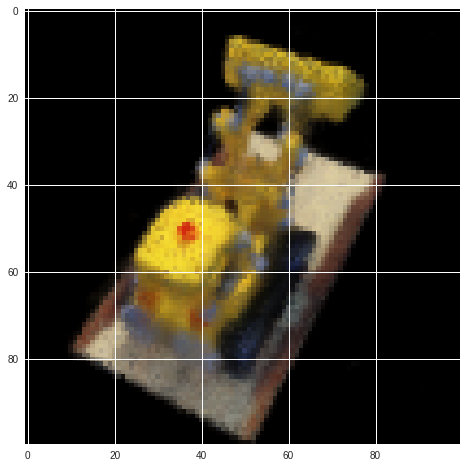

Loss at iteration 1275 is 0.0028013039845973253
PSNR at iteration 1275 is 23.47936020126934
SSIM at iteration 1275 is 0.862578614517691


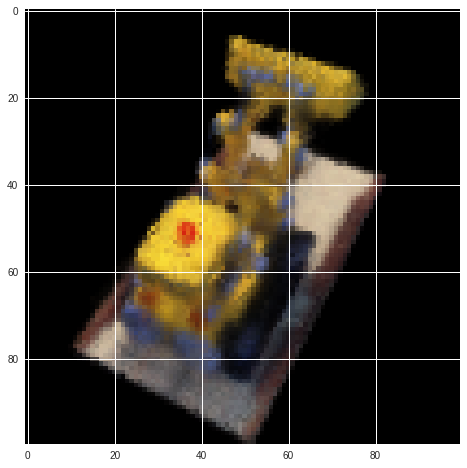

Loss at iteration 1300 is 0.004691050387918949
PSNR at iteration 1300 is 24.63944711967995
SSIM at iteration 1300 is 0.8796454868138599


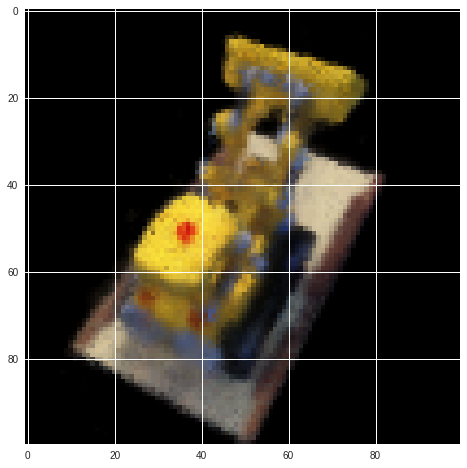

Loss at iteration 1325 is 0.0036183686461299658
PSNR at iteration 1325 is 25.021379050686463
SSIM at iteration 1325 is 0.8790258702639835


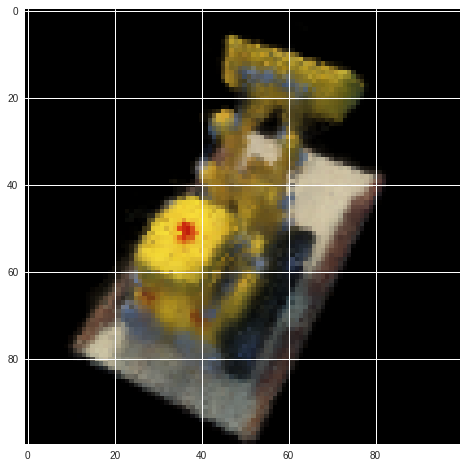

Loss at iteration 1350 is 0.004400224890559912
PSNR at iteration 1350 is 24.18551906269951
SSIM at iteration 1350 is 0.8705535946694813


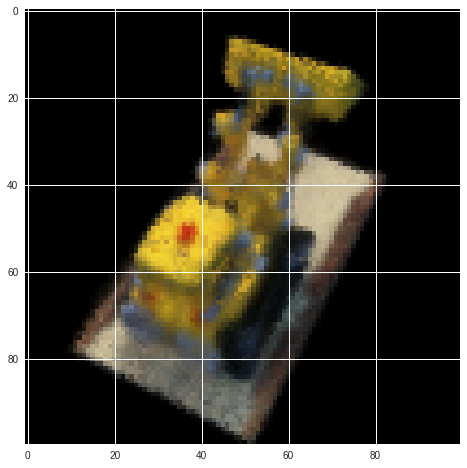

Loss at iteration 1375 is 0.00432973587885499
PSNR at iteration 1375 is 24.154093497156897
SSIM at iteration 1375 is 0.8696549945992594


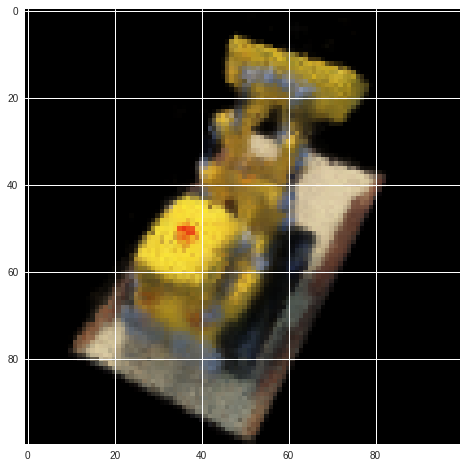

Loss at iteration 1400 is 0.0025808762293308973
PSNR at iteration 1400 is 24.162169919273282
SSIM at iteration 1400 is 0.8763035917381685


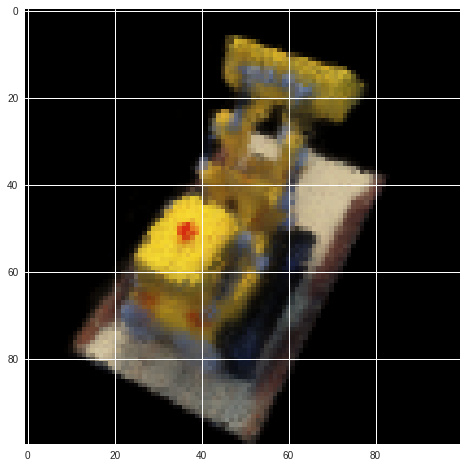

Loss at iteration 1425 is 0.0024641777854412794
PSNR at iteration 1425 is 25.278611024215948
SSIM at iteration 1425 is 0.8875624459986127


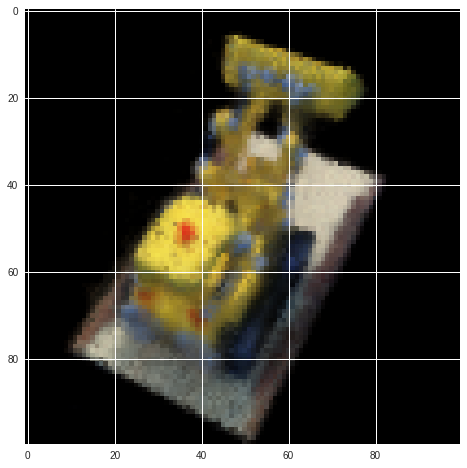

Loss at iteration 1450 is 0.0033491363283246756
PSNR at iteration 1450 is 24.080349550601877
SSIM at iteration 1450 is 0.8584001211125305


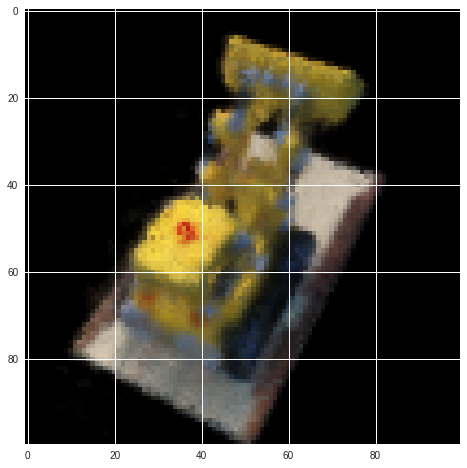

Loss at iteration 1475 is 0.0028826496563851833
PSNR at iteration 1475 is 25.16334391359537
SSIM at iteration 1475 is 0.8900883301603602


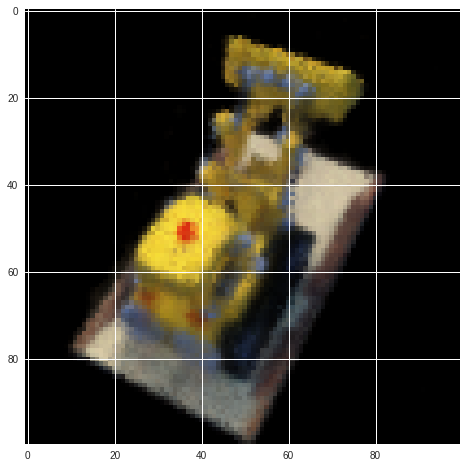

Loss at iteration 1500 is 0.0032552159391343594
PSNR at iteration 1500 is 23.61207652541625
SSIM at iteration 1500 is 0.8654999192970919


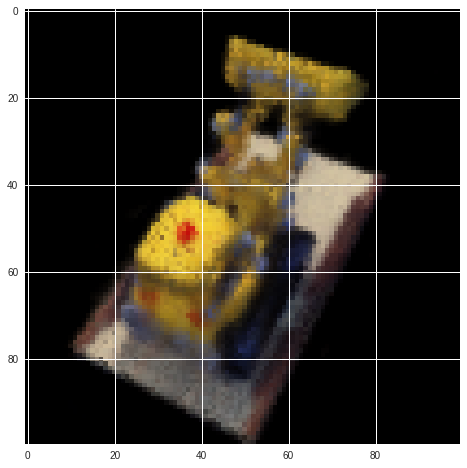

Loss at iteration 1525 is 0.0026554150972515345
PSNR at iteration 1525 is 25.147346385172522
SSIM at iteration 1525 is 0.8877275190923364


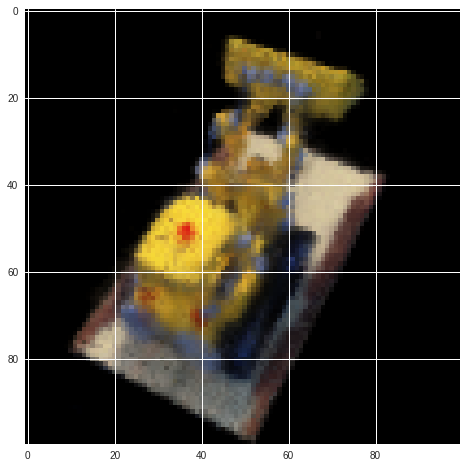

Loss at iteration 1550 is 0.0035853656008839607
PSNR at iteration 1550 is 24.066213741020736
SSIM at iteration 1550 is 0.8644248259867138


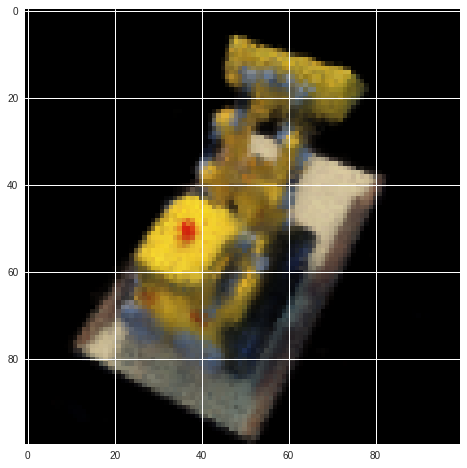

Loss at iteration 1575 is 0.0039130342192947865
PSNR at iteration 1575 is 24.86548546594299
SSIM at iteration 1575 is 0.8783382968453388


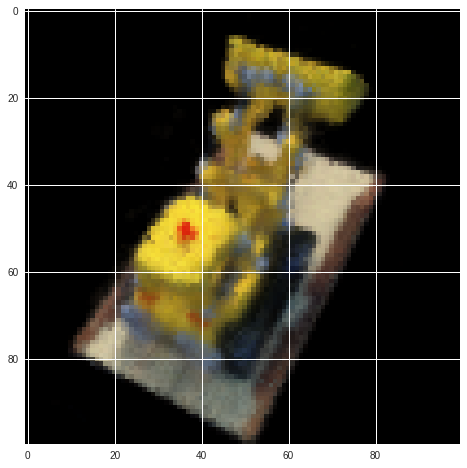

Loss at iteration 1600 is 0.0036595393903553486
PSNR at iteration 1600 is 23.955119448493623
SSIM at iteration 1600 is 0.8635880198619927


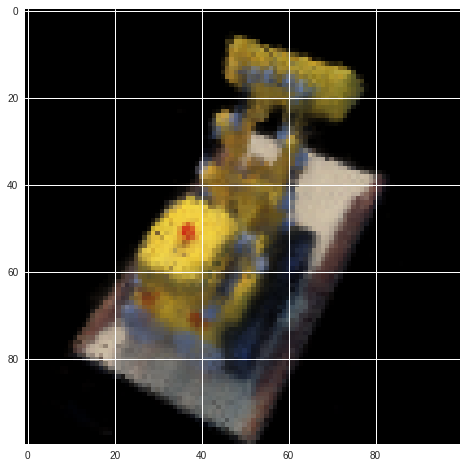

Loss at iteration 1625 is 0.002322188578546047
PSNR at iteration 1625 is 23.560758110937737
SSIM at iteration 1625 is 0.8511496288551575


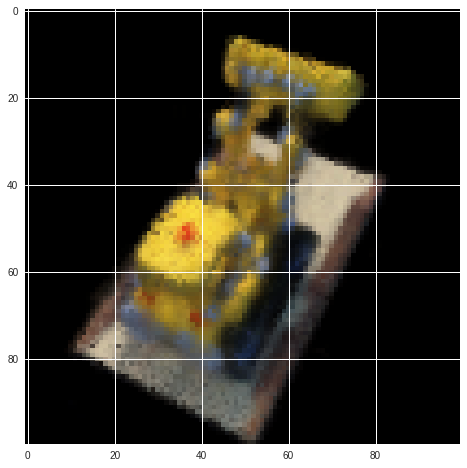

Loss at iteration 1650 is 0.003282741876319051
PSNR at iteration 1650 is 24.864114545060666
SSIM at iteration 1650 is 0.8783266388486606


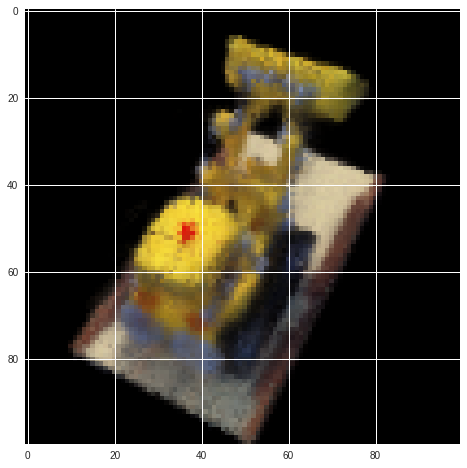

Loss at iteration 1675 is 0.0037213359028100967
PSNR at iteration 1675 is 24.249339364438697
SSIM at iteration 1675 is 0.8677601773608734


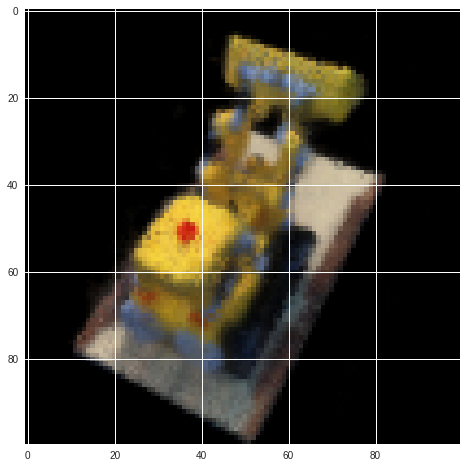

Loss at iteration 1700 is 0.0019576477352529764
PSNR at iteration 1700 is 23.924776951865592
SSIM at iteration 1700 is 0.874114261111296


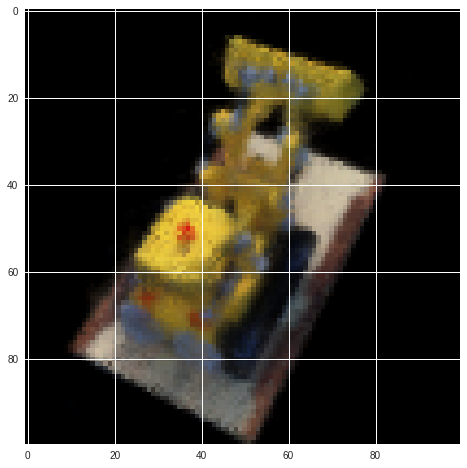

Loss at iteration 1725 is 0.003109545912593603
PSNR at iteration 1725 is 24.836232250861936
SSIM at iteration 1725 is 0.8769476577957149


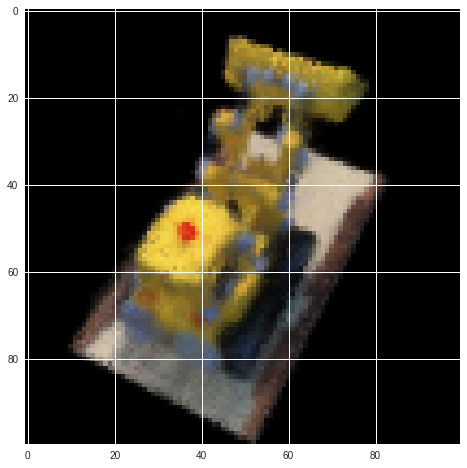

Loss at iteration 1750 is 0.0034846714697778225
PSNR at iteration 1750 is 25.00293995773151
SSIM at iteration 1750 is 0.8809544694446547


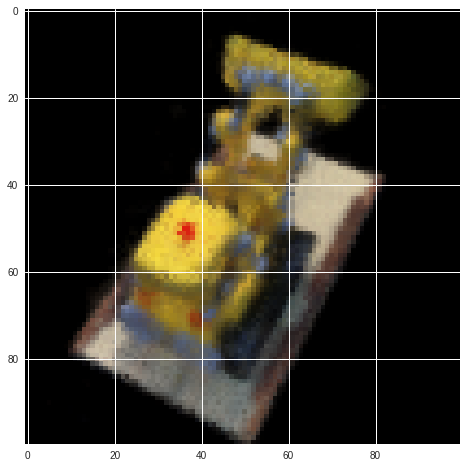

Loss at iteration 1775 is 0.0022919666953384876
PSNR at iteration 1775 is 24.352657512081954
SSIM at iteration 1775 is 0.8780658521083791


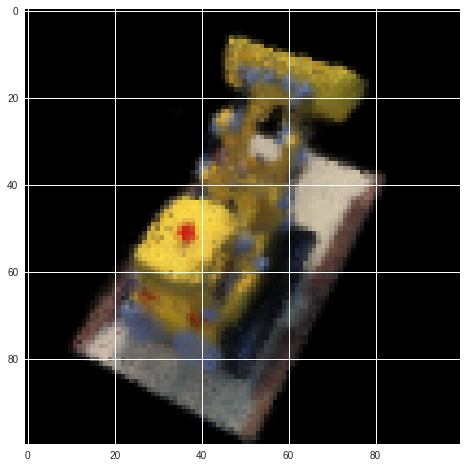

Loss at iteration 1800 is 0.0020507804583758116
PSNR at iteration 1800 is 24.463892624276735
SSIM at iteration 1800 is 0.8723916654832566


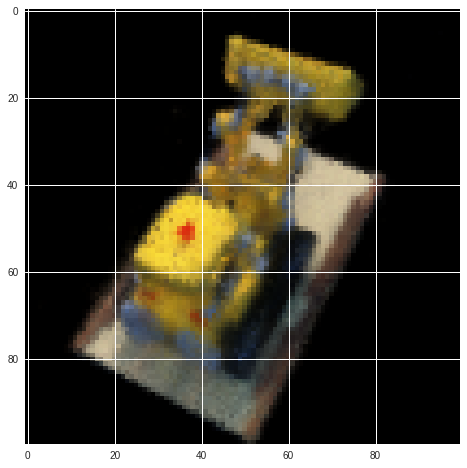

Loss at iteration 1825 is 0.002177449641749263
PSNR at iteration 1825 is 25.410252562958135
SSIM at iteration 1825 is 0.8769210090286161


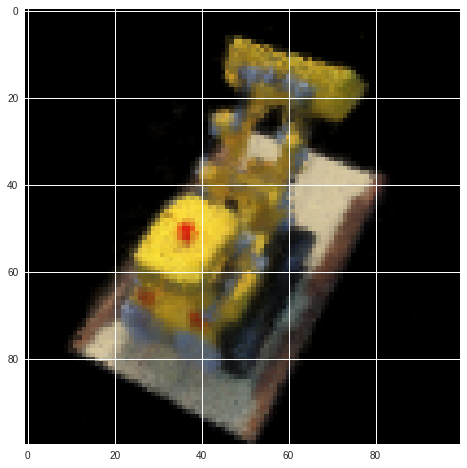

Loss at iteration 1850 is 0.0027007816825062037
PSNR at iteration 1850 is 23.480994123589813
SSIM at iteration 1850 is 0.8608170629389632


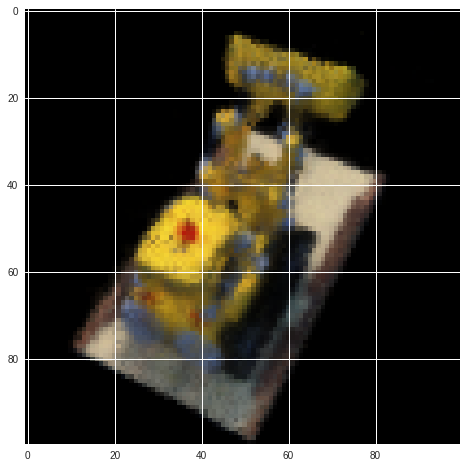

Loss at iteration 1875 is 0.0035098728258162737
PSNR at iteration 1875 is 24.324916037550896
SSIM at iteration 1875 is 0.8373977002652093


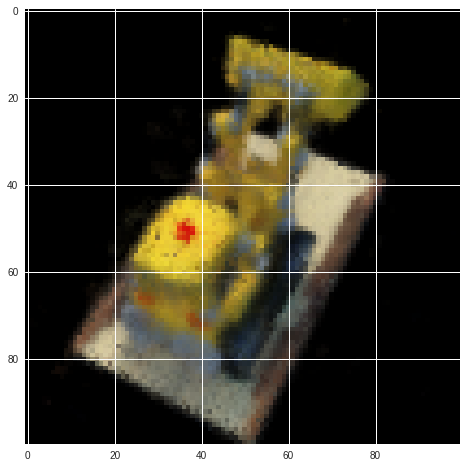

Loss at iteration 1900 is 0.0021909400820732117
PSNR at iteration 1900 is 25.372171197240636
SSIM at iteration 1900 is 0.8976313517711563


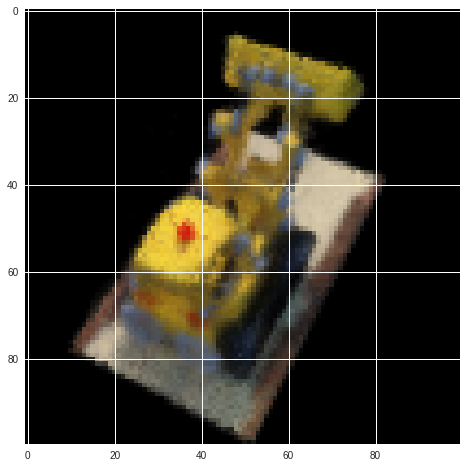

Loss at iteration 1925 is 0.003013867186382413
PSNR at iteration 1925 is 24.83485097559229
SSIM at iteration 1925 is 0.8825771590438933


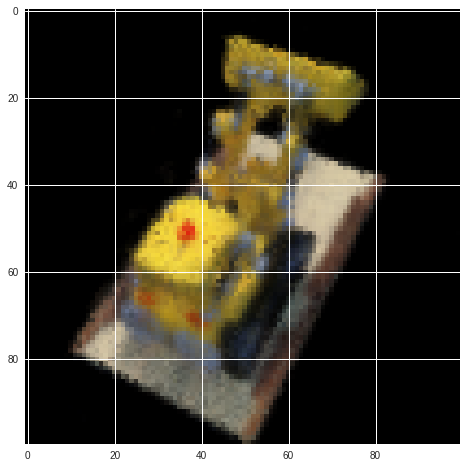

Loss at iteration 1950 is 0.004068980924785137
PSNR at iteration 1950 is 25.247150253756416
SSIM at iteration 1950 is 0.882515241283234


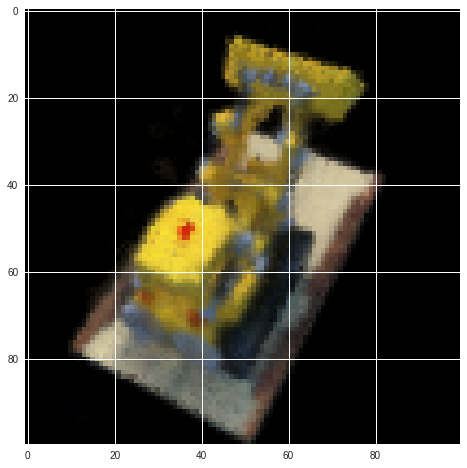

Loss at iteration 1975 is 0.002898271195590496
PSNR at iteration 1975 is 25.07615790141023
SSIM at iteration 1975 is 0.8887852428449805


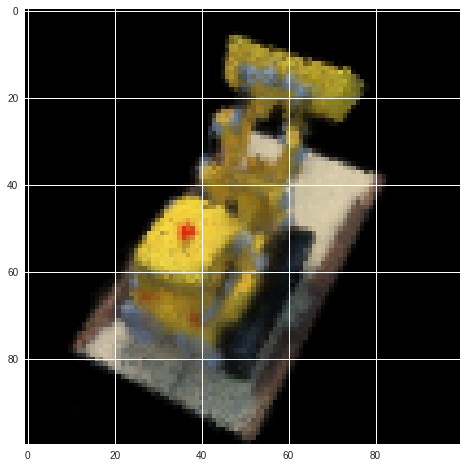

In [14]:
torch.manual_seed(42)
np.random.seed(2132)

torch.cuda.empty_cache()
nerf_model = NeRF_MLP_reduced(W=hparams['network_width'], inp_dim=3+6*hparams['L'])
nerf_model = nerf_model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(nerf_model.parameters(), lr=hparams['lr'])
optimizer.zero_grad(set_to_none=True)
iterations = hparams['iterations']
num_samples = hparams['num_samples']
focal = torch.tensor(f).to(device)
loss_arr = []
psnr_arr = []
ssim_arr = []
iter_arr = []
for iter in range(iterations):
    rand_index = np.random.randint(images.shape[0])
    img = images[rand_index]
    pos = poses[rand_index]
    pose = torch.tensor(pos).to(device)

    dir_rays, origin_rays = project_rays(H, W, focal, pose)

    if(iter<0):
      optimizer.zero_grad(set_to_none=True)
    else:
      optimizer.zero_grad()
    
    pred_rgb, depth, acc = render_rays(
        nerf_model,
        origin_rays,
        dir_rays,
        near=hparams['near'],
        far=hparams['far'],
        N_samples=hparams['num_samples'],
        rand=True,
        L=hparams['L'],
        batch_size=hparams['batch_size']
    )
    target = torch.tensor(img).to(device)
    loss = criterion(pred_rgb,target)
    loss.backward()
    optimizer.step()
    loss_arr.append(loss.item())
    
    if(iter % 25 == 0):
      print("Loss at iteration", iter, "is", loss.detach().item())
      with torch.no_grad():
        target = torch.from_numpy(testimg).to(device)
        pose = torch.from_numpy(testpose).to(device)
        dir_rays, origin_rays = project_rays(H, W, focal, pose)
        pred_rgb, depth, acc = render_rays(
            nerf_model,
            origin_rays,
            dir_rays,
            near=hparams['near'],
            far=hparams['far'],
            N_samples=hparams['num_samples'],
            rand=True,
            L=hparams['L'],
            batch_size=hparams['batch_size']
        )     
        iter_arr.append(iter)

        psnr = get_psnr(target[..., :3].cpu().detach().numpy(), pred_rgb.cpu().detach().numpy())
        psnr_arr.append(psnr)
        print("PSNR at iteration", iter, "is", psnr)
        
        target_np = target[..., :3].cpu().detach().numpy()
        pred_np = pred_rgb.cpu().detach().numpy()
        
        iter_ssim = get_color_ssim(target_np, pred_np)
        ssim_arr.append(iter_ssim)
        print("SSIM at iteration", iter, "is", iter_ssim)
        
        plt.imshow(pred_rgb.detach().cpu())
        plt.show()

Now, we can look at the training curves!

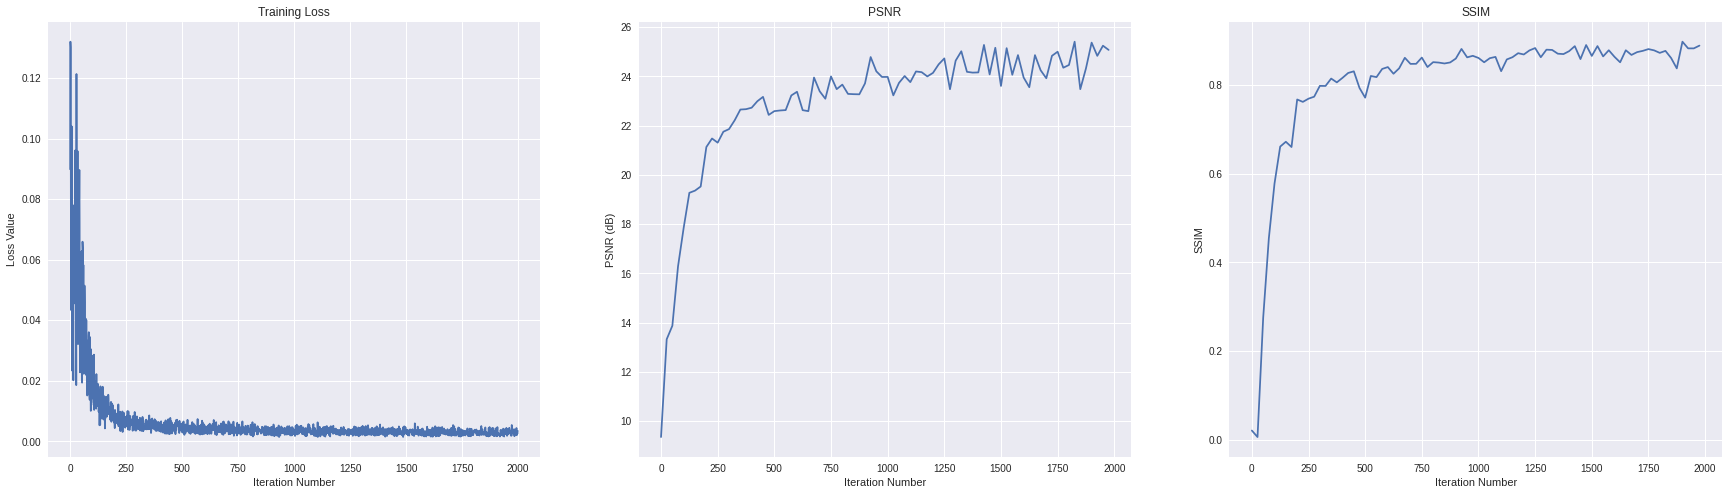

In [15]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.plot(np.arange(len(loss_arr)),loss_arr)
plt.title('Training Loss')
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.subplot(132)
plt.plot(iter_arr, psnr_arr)
plt.title('PSNR')
plt.xlabel('Iteration Number')
plt.ylabel('PSNR (dB)')
plt.subplot(133)
plt.plot(iter_arr, ssim_arr)
plt.title('SSIM')
plt.xlabel('Iteration Number')
plt.ylabel('SSIM')
plt.savefig('training_curves.png')
plt.show()

# Inference

We provide the two inference results to qualitatively and quantively display the performance of our model.

1. We display ground-truth images and predicted rendered images for 5 samples from the training and testing viewpoints for 2 different synthetic datasets. We also display the PSNR and SSIM for each pair.
2. We display video results for 2 different synthetic datasets, where we generate images along a continously moving camera path. 

First, let us re-load the train and test data

In [25]:
path = os.path.join(GOOGLE_DRIVE_PATH, name+'_data100x100_train.npz')
train_data = np.load(path, allow_pickle=True)
train_images = data['images'][..., :3]
train_poses = data['poses']
f = data['focal']
H, W = images.shape[1:3]

path = os.path.join(GOOGLE_DRIVE_PATH, name+'_data100x100_test.npz')
test_data = np.load(path, allow_pickle=True)
test_images = data['images'][..., :3]
test_poses = data['poses']

## Ground-Truth Comparison

First, let us see the comparison between the ground truth and the predicted image in the train set.


PSNR: 24.914672947509253
SSIM: 0.8782804029028966


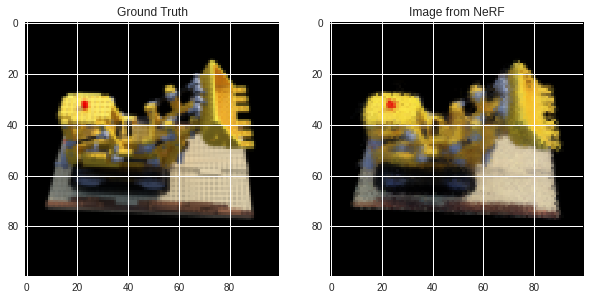

PSNR: 26.255671721326948
SSIM: 0.8893055748425289


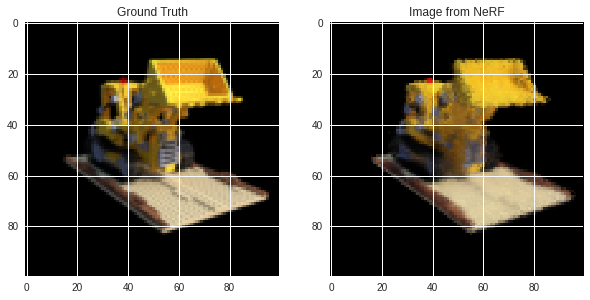

PSNR: 26.89805169856724
SSIM: 0.8984962190174147


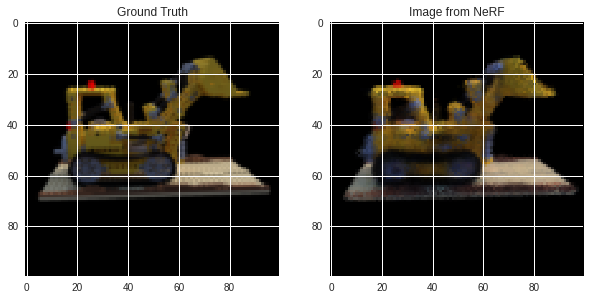

PSNR: 25.12475932465369
SSIM: 0.9055354829763523


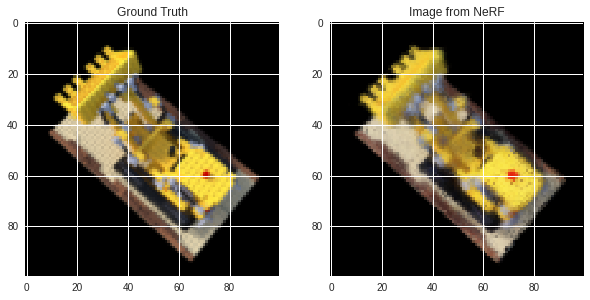

PSNR: 24.76690134418641
SSIM: 0.8985459276657137


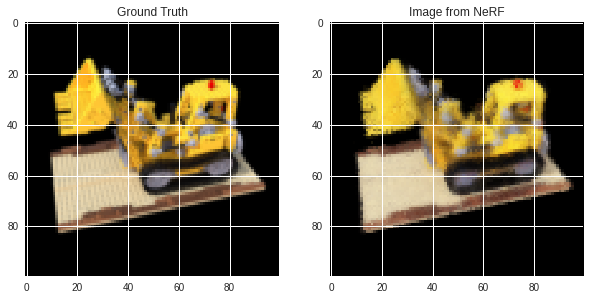

PSNR: 23.757251248397054
SSIM: 0.8829385833967424


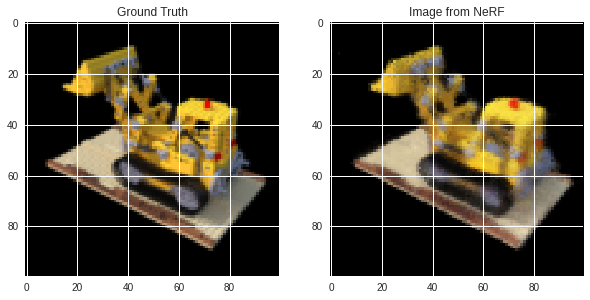

In [29]:
indices = [2,3,5,7,11,13]
for i in indices:
    f0, axarr = plt.subplots(1,2)
    gt = train_images[i]
    pred = get_image_from_pose(H, W, f, train_poses[i], nerf_model, device).cpu().detach().numpy()
    axarr[0].imshow(gt)
    axarr[0].set_title('Ground Truth')
    axarr[1].imshow(pred)
    axarr[1].set_title('Image from NeRF')
    print("PSNR:", get_psnr(gt, pred))
    print("SSIM:", get_color_ssim(gt, pred))
    plt.show()

Next, let us see the comparison between the ground truth and the predicted image in the train set.

PSNR: 24.864679894608813
SSIM: 0.8756509522711445


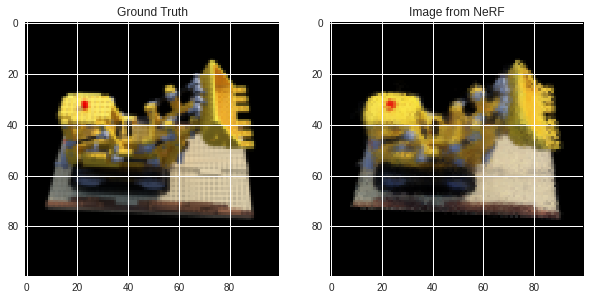

--------------------------------------------------------
PSNR: 26.390508623998777
SSIM: 0.8913354385949882


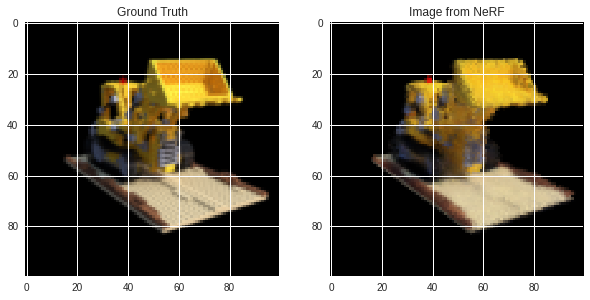

--------------------------------------------------------
PSNR: 26.91937552383197
SSIM: 0.8983330092573357


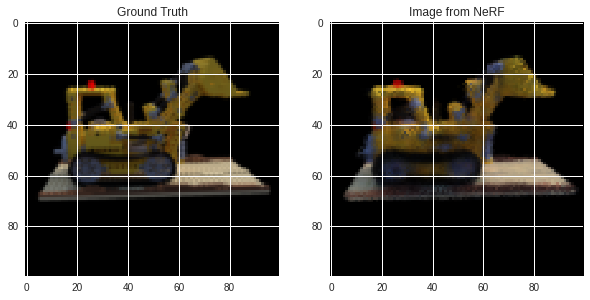

--------------------------------------------------------
PSNR: 24.87703060781449
SSIM: 0.9029266515481791


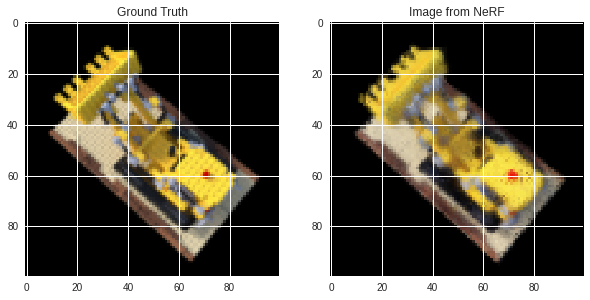

--------------------------------------------------------
PSNR: 24.679704977613945
SSIM: 0.8967648871412586


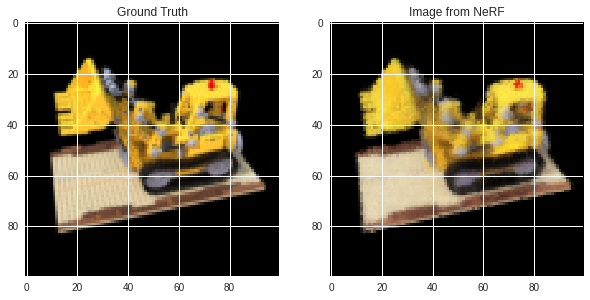

--------------------------------------------------------
PSNR: 23.784238923530584
SSIM: 0.8823710454861368


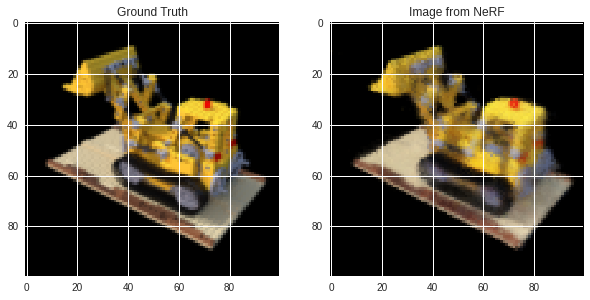

--------------------------------------------------------


In [30]:
indices = [2,3,5,7,11,13]
for i in indices:
    f0, axarr = plt.subplots(1,2)
    gt = test_images[i]
    pred = get_image_from_pose(H, W, f, test_poses[i], nerf_model, device).cpu().detach().numpy()
    axarr[0].imshow(gt)
    axarr[0].set_title('Ground Truth')
    axarr[1].imshow(pred)
    axarr[1].set_title('Image from NeRF')
    print("PSNR:", get_psnr(gt, pred))
    print("SSIM:", get_color_ssim(gt, pred))
    plt.show()
    print("--------------------------------------------------------")

## Video Results


Finally, we will look at visualization of the NeRF result. The notebook might not have the video embedded in it, but we have included it in the zip folder.

In [31]:
torch.cuda.empty_cache()
focal = torch.tensor(f).to(device)
frames=[]
for theta in torch.arange(0,360,2, dtype=torch.float32):
    rot_mat_theta = torch.eye(4, dtype=theta.dtype, device=device)
    rot_mat_theta[:2,:2] = rotation_mat(theta*(np.pi/180), theta.dtype ,device)
    camera_mat = rot_mat_theta @ torch.tensor(data['poses'][1]).to(device)
    dir_rays, origin_rays = project_rays(H, W, focal, camera_mat)
    rgb, _, _ = render_rays(nerf_model, origin_rays.to(device), dir_rays.to(device), near=2., far=6., N_samples=num_samples, rand=True, batch_size=1024, L=6)
    final_img = (255*rgb).to(torch.uint8)

    if device == 'cpu':
        final_img = final_img.numpy()
    else:
        final_img = final_img.cpu().detach().numpy()

    frames.append(final_img)

video_file_name = name + '_video.mp4'
imageio.mimwrite(video_file_name, frames, fps=30, quality=7)

In [39]:
from IPython.display import HTML
from base64 import b64encode
path = name+'_video.mp4'
mp4 = open(path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
<source src="%s" type="video/mp4">
</video>
""" % data_url)

# Conclusion/Future Work

NeRF provides an robust deep learning implementation to synthesize novel views of a 3D scene. Apart from the model architecture proposed in the paper, one other major contribution of the authors is the differentiable volume rendering that plays an important role as it ensures that the neural model is differentiable end-to-end and therefore allows gradient backpropogation. One major drawback of NeRF that we observed and also mentioned in the class, is that we have to train the model for each 3D scene separately. 

We coded the whole implementation from scratch and hence we got a better understanding of underlying nuances of structuring the problem and training the models. The assignments of the course was in a controlled environment and we knew what to expect along the way so we could easily debug where we went wrong if our code threw some error. Understanding and implementating the rendering part of the project was the most challenging since we didn't have any sanity checks to ensure that we were in the right path. We experimented on different types of models that helped us understand the problems behind getting the hyperparameters right for training the models. 

The biggest restriction we had is the limited resources of Colab. Our implementation gave pretty good results(as seen above) for 100x100 resolution images and we were really interested to see results for 200x200 and 400x400 but we couldn't.